In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
img_grid_path = 'metalgrid.jpg'
img_web_path = 'tela2.jpg'

def load_img(filename):
    img = cv.imread('img/' + filename)
    #img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    return img

In [43]:
def normalize(img_in):
    img = img_in.copy()
    img = img + np.abs(img.min())
    img = img / img.max()
    return img

In [44]:
def plot_results(img, fsize=(8, 8)):
    fig = plt.figure(figsize=fsize, dpi=130)
    if len(img) == 1:
        ax1=plt.subplot(111)
        ax1.imshow(normalize(img[0]), cmap='gray')
    if len(img) == 2:
        ax1=plt.subplot(121)
        ax1.imshow(normalize(img[0]), cmap='gray')
        ax2=plt.subplot(122)
        ax2.imshow(normalize(img[1]), cmap='gray')

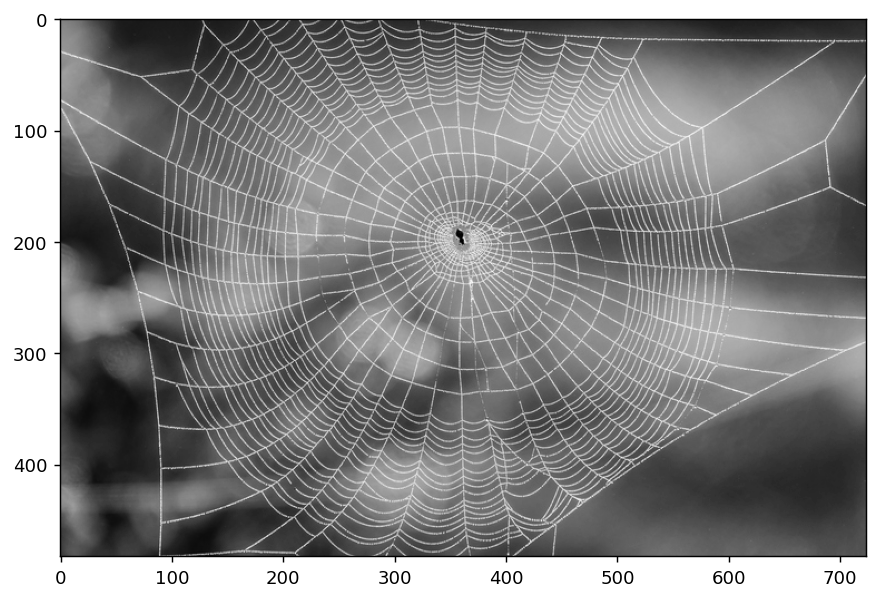

In [45]:
img_grid = load_img(img_web_path)
plot_results([img_grid])

In [46]:
# Reducir ruido usando un filtro de gauss
img_grid_blur = cv.GaussianBlur(img_grid,(5,5),0)

In [47]:
# Filto Sobel en las dos direcciones
Gx = cv.Sobel(img_grid_blur,cv.CV_64F,1,0,ksize=5)
Gy = cv.Sobel(img_grid_blur,cv.CV_64F,0,1,ksize=5)

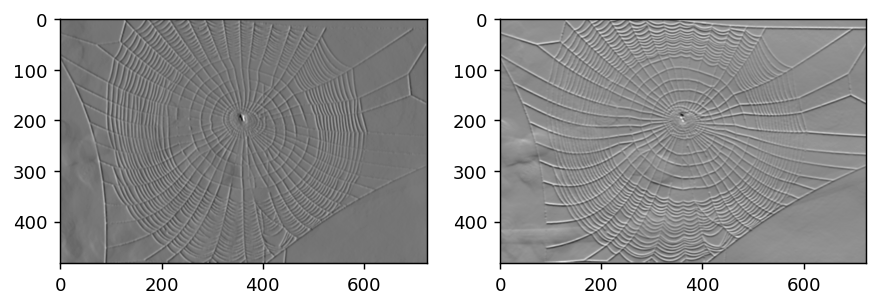

In [48]:
plot_results([Gx, Gy])

In [49]:
# Encontrar gradiente de intensidad
G = (Gx**2 + Gy**2)**0.5
tita = np.arctan2(Gy, Gx)

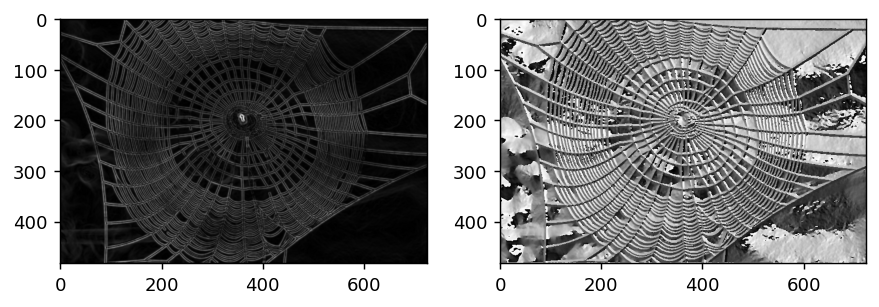

In [50]:
plot_results([G, tita])

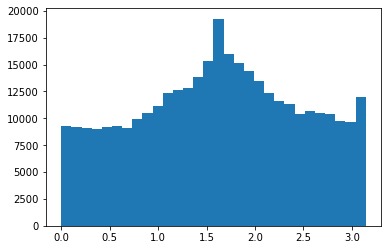

In [51]:
# Histograma de direcciones del gradiente
tita[tita <= 0] += np.pi
plt.hist(tita.ravel(), bins=30, range=(0, np.pi));

In [52]:
# Umbral de magnitud del gradiente
p = 90
limit = np.percentile(G.ravel(),p).round()
print("Magnitud minima: " + str(G.min()))
print("Magnitud minima: " + str(G.max()))
print("Percentil " + str(p) + ": " + str(limit))

Magnitud minima: 0.0
Magnitud minima: 6130.824577493634
Percentil 90: 1600.0


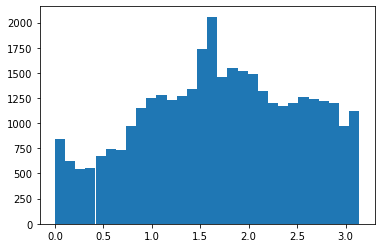

In [53]:
# Histograma de direcciones del gradiente con umbral de magnitud
tita_f = tita[G > limit]
plt.hist(tita_f.ravel(), bins=30);

In [54]:
# Filtrar N bins y calcular medias (Direcciones principales)
N = 3
hist, bin_edges = np.histogram(tita_f.ravel(), bins=40)
idx = np.argsort(hist*-1)[:N]
means = ((bin_edges[idx + 1] + bin_edges[idx])/2)
print("Direcciones principales (deg): " + str(means*180/np.pi))

Direcciones principales (deg): [92.26076366 87.76131564 96.76021168]


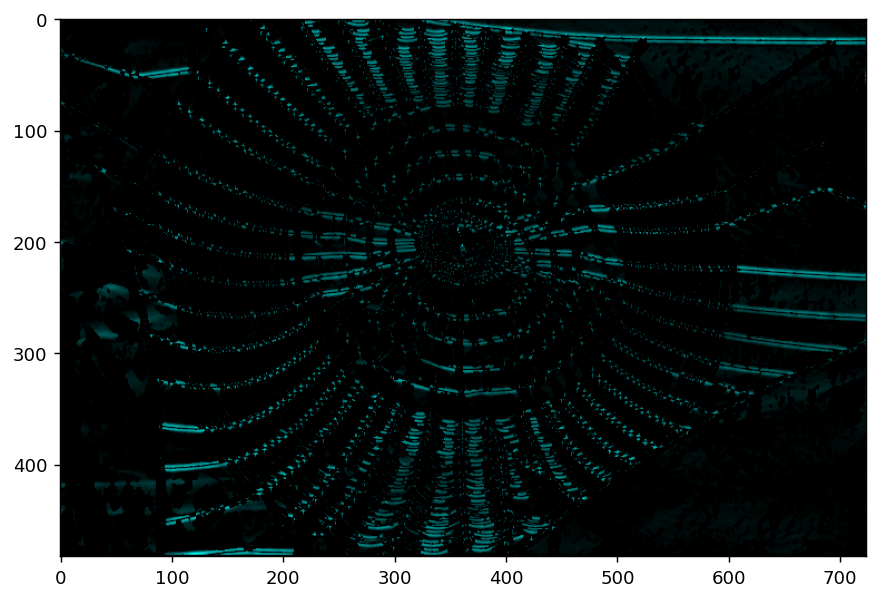

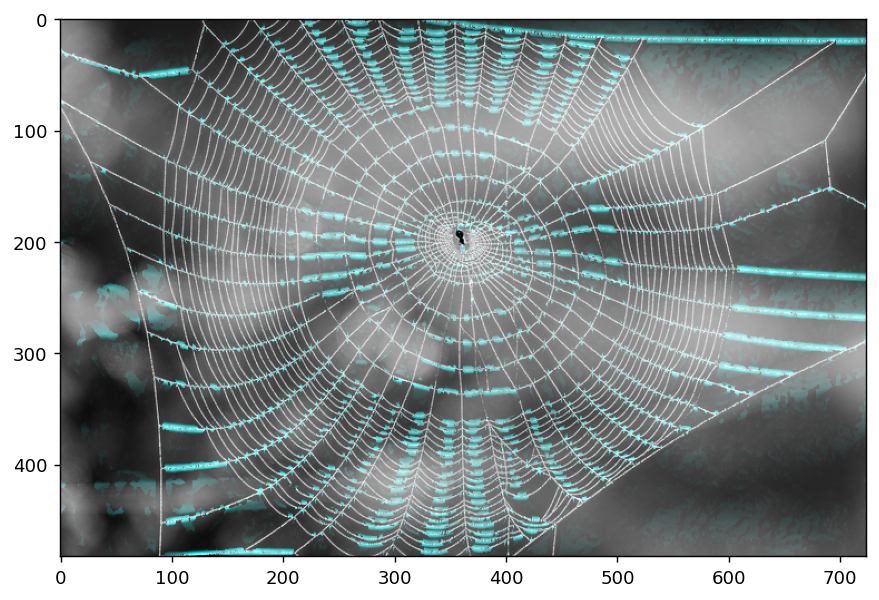

In [55]:
# Detectar bordes con cierta dirección en la imagen
deg = 90
tol_deg = 15

rad = deg*np.pi/180.0
tol_deg = tol_deg*np.pi/180.0
borders = G.copy()
limit = np.percentile(G.ravel(),5).round()
borders[G < limit] = 0
borders[~((tita > rad-tol_deg)&(tita < rad+tol_deg))] = 0
borders_n = (255*normalize(borders)).astype('uint8')
borders_rgb = cv.merge((0*borders_n,borders_n,borders_n))
plot_results([borders_rgb])

# Mostrar bordes en la imagen original
img_grid_rgb = cv.cvtColor(img_grid,cv.COLOR_GRAY2RGB)
result = cv.addWeighted(img_grid_rgb, 1.0, borders_rgb, 1.0, 0)
plot_results([result])

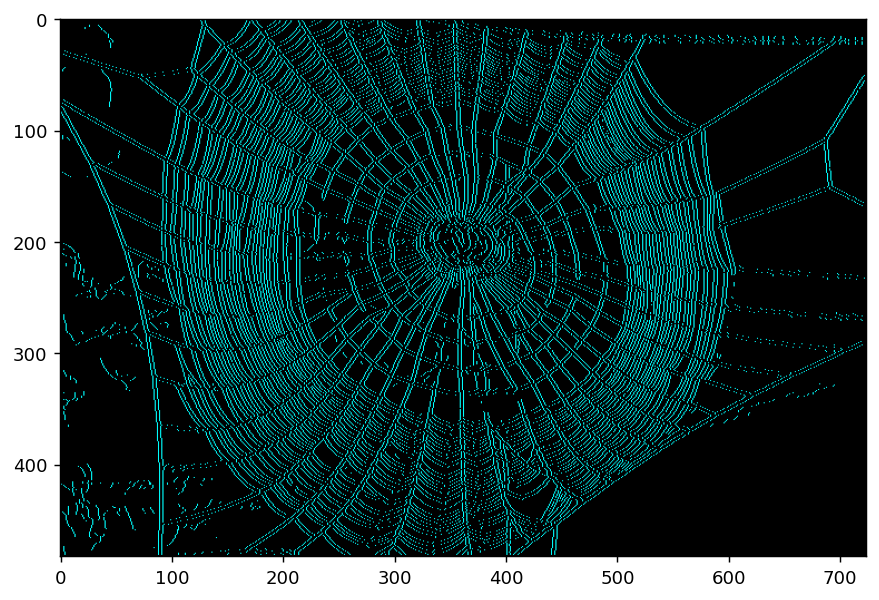

In [73]:
# Solución con supresión de no maximos

M, N = borders.shape
Non_max = np.zeros((M,N), dtype= np.uint8)
angle = np.rad2deg(tita)

G_f = G.copy()
G_f[G < np.percentile(G,50)] = 0

for i in range(1,M-1):
    for j in range(1,N-1):
       # Horizontal 0
        if (0 <= tita[i,j] < 22.5) or (157.5 <= tita[i,j] <= 180) or (-22.5 <= tita[i,j] < 0) or (-180 <= tita[i,j] < -157.5):
            b = G_f[i, j+1]
            c = G_f[i, j-1]
        # Diagonal 45
        elif (22.5 <= tita[i,j] < 67.5) or (-157.5 <= tita[i,j] < -112.5):
            b = G_f[i+1, j+1]
            c = G_f[i-1, j-1]
        # Vertical 90
        elif (67.5 <= tita[i,j] < 112.5) or (-112.5 <= tita[i,j] < -67.5):
            b = G_f[i+1, j]
            c = G_f[i-1, j]
        # Diagonal 135
        elif (112.5 <= tita[i,j] < 157.5) or (-67.5 <= tita[i,j] < -22.5):
            b = G_f[i+1, j-1]
            c = G_f[i-1, j+1]           
            
        # Supresión de no-máximos
        if (G_f[i,j] >= b) and (G_f[i,j] >= c):
            Non_max[i,j] = G_f[i,j]
        else:
            Non_max[i,j] = 0

limit = np.percentile(Non_max,70)
Non_max[Non_max > limit] = 255
Non_max[Non_max <= limit] = 0
borders_n = (255*normalize(Non_max)).astype('uint8')
borders_rgb = cv.merge((0*borders_n,borders_n,borders_n))
plot_results([borders_rgb])


# # Mostrar bordes en la imagen original
# img_grid_rgb = cv.cvtColor(img_grid,cv.COLOR_GRAY2RGB)
# result = cv.addWeighted(img_grid_rgb, 0.04, borders_rgb, 100.0, 0)
# plot_results([result])

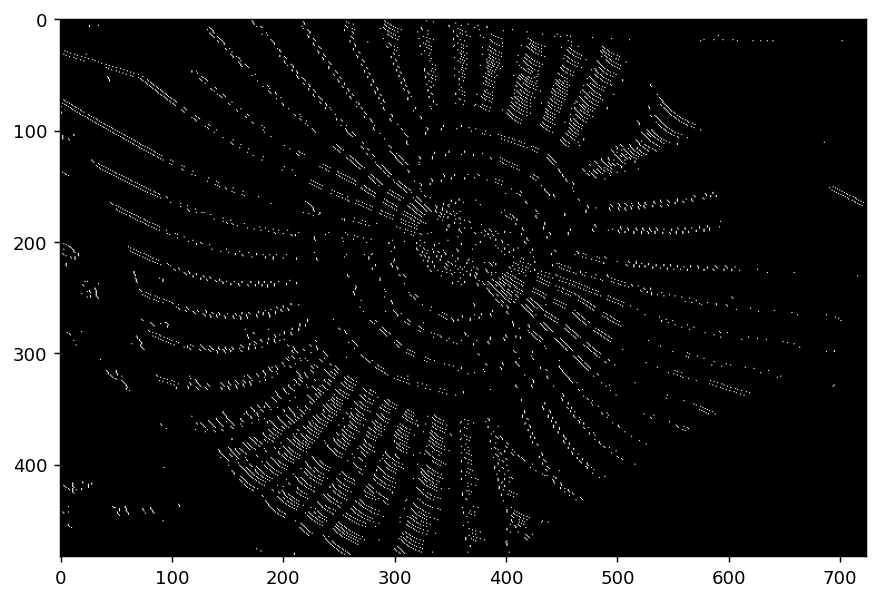

In [81]:
# Filtrado del resultado a la dirección de interés

deg = 120
tol_deg = 20

result = Non_max.copy()
result[~((angle>(deg-tol_deg))&(angle<(deg+tol_deg)))] = 0

plot_results([result])